<a href="https://colab.research.google.com/github/junfeiai/CCGAN_OPF_Journal2022/blob/main/linear_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.io import loadmat
import numpy as np
import math
import tensorflow as tf
import matplotlib

In [2]:
'''
#This is the block to load data from matlab, and cvs dataset
#Then process them ready for the neural network training
'''
#Load grid data from matlab
mat_y = loadmat('/content/drive/MyDrive/Phd/opf_gan/Y_bus118.mat')
mat_gen = loadmat('/content/drive/MyDrive/Phd/opf_gan/IEEE118_gen.mat')['gen118']
mat_load = loadmat('/content/drive/MyDrive/Phd/opf_gan/IEEE118_load.mat')
#mat_gencost = pd.read_csv('new_cost.csv').values[:,1:]
mat_gencost = loadmat('/content/drive/MyDrive/Phd/opf_gan/case118_gencost.mat')['gencost']
line_constraints = loadmat('/content/drive/MyDrive/Phd/opf_gan/grid118_line_constraints.mat')['line_constraint']

#Load dataset
conditions = loadmat('/content/drive/MyDrive/Phd/icnn_gan/118_condition_0325.mat')['conditions_list']
solutions = loadmat('/content/drive/MyDrive/Phd/icnn_gan/118_solution_0325.mat')['datapoints_list']

Y_bus = mat_y['Y_bus118'].toarray().astype('complex64')

grid_size = 118
baseMVA = 100
gen_size = 54

In [3]:
def disassemble_mp_structure(condition,solution):
    demand_p = condition[:,0:grid_size]/baseMVA
    demand_q = condition[:,grid_size:grid_size*2]/baseMVA
    vm = solution[:,0:grid_size]
    va = solution[:,grid_size:grid_size*2]

    matpower_p = solution[:,grid_size*2:grid_size*2+gen_size]
    matpower_q = solution[:,grid_size*2+gen_size:]
    p = np.zeros(vm.shape)
    q = np.zeros(va.shape)
    gen_ids = mat_gen[:,0]-1
    j=0
    gen_pos = np.zeros(grid_size)
    for i in range(0,grid_size):
      if i in gen_ids:
        p[:,i]=matpower_p[:,j]
        q[:,i]=matpower_q[:,j]
        j=j+1
        gen_pos[i]=1
    p=p/baseMVA
    q=q/baseMVA
    #gen_pos_tf = tf.convert_to_tensor(gen_pos,dtype='float32')
    gen_pos = gen_pos
    return demand_p,demand_q,vm,va,p,q

In [32]:
demand_p,demand_q,vm,phi,p,q = disassemble_mp_structure(conditions,solutions)
v_r = tf.math.multiply(vm,tf.cos(tf.math.multiply(phi,tf.constant(math.pi/180,dtype='float32'))))
v_i = tf.math.multiply(vm,tf.sin(tf.math.multiply(phi,tf.constant(math.pi/180,dtype='float32'))))
V = tf.complex(v_r,v_i)
#calculate current
Y_bus_tf = tf.convert_to_tensor(Y_bus)

In [93]:
def get_g1(index):
  g1 = tf.reshape(V[index,0],[-1,1])*tf.reshape(Y_bus_tf[0,:],[1,118])
  g1 = g1.numpy()
  g1[:,0]=V[index,0]*Y_bus_tf[0,0]+tf.math.reduce_mean(tf.reshape(V[index,:],[-1,1])*Y_bus_tf[0,:])
  return g1

In [87]:
"""g1 = tf.reshape(V[1:3,0],[-1,1])*tf.reshape(Y_bus_tf[0,:],[1,118])
g1 = g1.numpy()
g1[:,0]=V[1:3,0]*Y_bus_tf[0,0]+tf.math.reduce_mean(tf.reshape(V[1:3,:],[-1,1])*Y_bus_tf[0,:])"""

In [98]:
U = get_g1(0).flatten()
K = get_g1(1).flatten()

In [104]:
ll = []
for i in range(0,1000):
  ram = np.random.randint(0,200000,2)
  U = get_g1(ram[0]).flatten()
  #ram = np.random.randint(0,240000,1)
  K = get_g1(ram[1]).flatten()
  diff = np.real(np.dot(U,K))/(np.sqrt(abs(np.sum(U*np.conj(U))))*np.sqrt(abs(np.sum(K*np.conj(K)))))
  ll.append(diff)
  print(diff)

-0.29739204
-0.3719274
-0.28349045
0.15748808
0.06955514
0.07298322
-0.34366733
-0.10260622
-0.38282987
-0.05940702
-0.20876427
-0.11615143
-0.33039394
-0.32957774
-0.32142895
-0.42104524
0.08268702
-0.14410257
-0.040134452
-0.08212921
-0.2319527
-0.056427244
-0.47488296
-0.18541774
-0.14022106
-0.120434985
-0.47492644
-0.07187426
0.14066434
-0.30683354
-0.20836471
0.05727701
-0.27144924
-0.14488715
-0.26949462
-0.33827376
0.08928368
0.031149445
-0.25786138
0.047709163
-0.5749288
0.28505427
-0.039922226
-0.15965843
-0.42678905
-0.3085947
0.37211883
-0.23777005
-0.6132889
-0.30225646
-0.27074012
-0.019010639
-0.56116074
0.25386474
0.30079958
-0.1844148
-0.041480314
-0.07154962
0.0071744854
-0.33786118
-0.2542366
0.13319008
-0.05703578
-0.33550745
0.03235975
-0.14824298
-0.36863032
0.29506528
-0.24858196
-0.40982488
-0.34629366
0.016440311
-0.2720752
-0.261109
-0.46655738
-0.41056886
0.3280684
-0.3601019
0.22318442
-0.47327226
0.038901962
-0.59052116
-0.3418719
-0.16330722
-0.3123258
-0.

In [110]:
np.degrees(np.arccos(np.array(ll)))

array([107.301025, 111.834526, 106.46863 ,  80.93887 ,  86.01156 ,
        85.814644, 110.10046 ,  95.88927 , 112.50908 ,  93.40577 ,
       102.04994 ,  96.67004 , 109.29268 , 109.24315 , 108.74936 ,
       114.90059 ,  85.256966,  98.28531 ,  92.30015 ,  94.71095 ,
       103.412056,  93.23476 , 118.35172 , 100.68548 ,  98.06063 ,
        96.917206, 118.35455 ,  94.12164 ,  81.913704, 107.8685  ,
       102.026535,  86.71647 , 105.75052 ,  98.330734, 105.63419 ,
       109.771736,  84.877594,  88.21497 , 104.94319 ,  87.26542 ,
       125.094635,  73.437904,  92.28798 ,  99.187065, 115.26395 ,
       107.974556,  68.15365 , 103.75496 , 127.82768 , 107.59318 ,
       105.708305,  91.08929 , 124.1361  ,  75.29367 ,  72.49436 ,
       100.627014,  92.37733 ,  94.103   ,  89.58892 , 109.74661 ,
       104.72835 ,  82.346016,  93.26968 , 109.60339 ,  88.14559 ,
        98.52511 , 111.631165,  72.83854 , 104.39361 , 114.19383 ,
       110.26077 ,  89.05799 , 105.78779 , 105.135864, 117.811

In [ ]:
g33 = V[:,3]*Y_bus_tf[3,3]+tf.reduce_sum(tf.math.conj(V)*Y_bus_tf[3,:],axis=1)

In [ ]:
g11_real = np.real(g33)
g11_imag = np.imag(g33)

(array([[2., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.]]),
 array([  1.16691399,   2.53381556,   3.90071712,   5.26761869,
          6.63452026,   8.00142183,   9.3683234 ,  10.73522497,
         12.10212654,  13.46902811,  14.83592968,  16.20283125,
         17.56973282,  18.93663439,  20.30353596,  21.67043753,
         23.0373391 ,  24.40424067,  25.77114223,  27.1380438 ,
         28.50494537,  29.87184694,  31.23874851,  32.60565008,
         33.97255165,  35.33945322,  36.70635479,  38.07325636,
         39.44015793,  40.8070595 ,  42.17396107,  43.54086264,
         44.90776421,  46.27466578,  47.64156734,  49.00846891,
         50.37537048,  51.74227205,  53.10917362,  54.47607519,
         55.84297676,  57.20987833,  58.5767799 ,  59.94368147,
         61.31058304,  62.67748461,  64.0443861

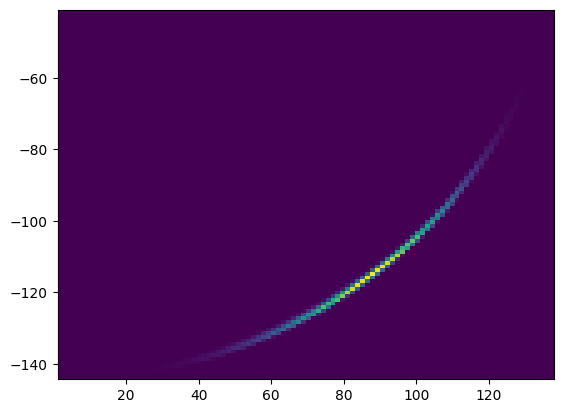

In [ ]:
matplotlib.pyplot.hist2d(g11_real,g11_imag,bins=100)